In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
import timm
from utils import *
import matplotlib.pyplot as plt


In [4]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = datasets.ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    def classes(self):
        return self.data.classes

In [5]:
# 设置设备和参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 40
learning_rate = 1e-3

pretrain_network = 'resnet18'

In [6]:
# 准备数据
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5]*3, [0.5]*3)
# ])

transform = v2.Compose([
                v2.ToImage(), 
                v2.ToDtype(torch.float32, scale=True),
                v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.3, 0.3)),
                v2.RandomChannelPermutation(),
                v2.RandomErasing(p=0.5, scale=(0.05, 0.3), ratio=(1, 1), value='random'),
                v2.RandomRotation(degrees=30)])

train_dataset = CropButtonDataset("../ClassificationDataset_label/train", transform=transform)
val_dataset   = CropButtonDataset("../ClassificationDataset_label/val", transform=transform)
test_dataset  = CropButtonDataset("../ClassificationDataset_label/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [7]:
# 加载模型
model = timm.create_model('resnet18', pretrained=True)
in_features = model.get_classifier().in_features

# custom MLP head
mlp_head = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    #nn.Linear(in_features, 1),

)

model.reset_classifier(0)  # 移除原有头部
model.fc = mlp_head        # 或 model.head = mlp_head，取决于模型定义


# # 加载模型
# model = timm.create_model(pretrain_network, pretrained=True)
# model.reset_classifier(num_classes=1)


model.to(device)

# 损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

Epoch 1/40
  Train Loss: 0.6947
  Val Loss:   0.6922, Val Acc: 50.00%
Epoch 2/40
  Train Loss: 0.6912
  Val Loss:   0.6952, Val Acc: 50.00%
Epoch 3/40
  Train Loss: 0.6867
  Val Loss:   0.6903, Val Acc: 50.00%
Epoch 4/40
  Train Loss: 0.6817
  Val Loss:   0.6918, Val Acc: 50.00%
Epoch 5/40
  Train Loss: 0.6755
  Val Loss:   0.6969, Val Acc: 50.00%
Epoch 6/40
  Train Loss: 0.6675
  Val Loss:   0.6855, Val Acc: 50.00%
Epoch 7/40
  Train Loss: 0.6716
  Val Loss:   0.6933, Val Acc: 50.00%
Epoch 8/40
  Train Loss: 0.6627
  Val Loss:   0.6961, Val Acc: 50.00%
Epoch 9/40
  Train Loss: 0.6358
  Val Loss:   0.6765, Val Acc: 50.00%
Epoch 10/40
  Train Loss: 0.6288
  Val Loss:   0.6872, Val Acc: 50.00%
Epoch 11/40
  Train Loss: 0.6205
  Val Loss:   0.6679, Val Acc: 50.00%
Epoch 12/40
  Train Loss: 0.5913
  Val Loss:   0.6582, Val Acc: 50.00%
Epoch 13/40
  Train Loss: 0.5657
  Val Loss:   0.6430, Val Acc: 60.00%
Epoch 14/40
  Train Loss: 0.5147
  Val Loss:   0.5999, Val Acc: 60.00%
Epoch 15/40
  T

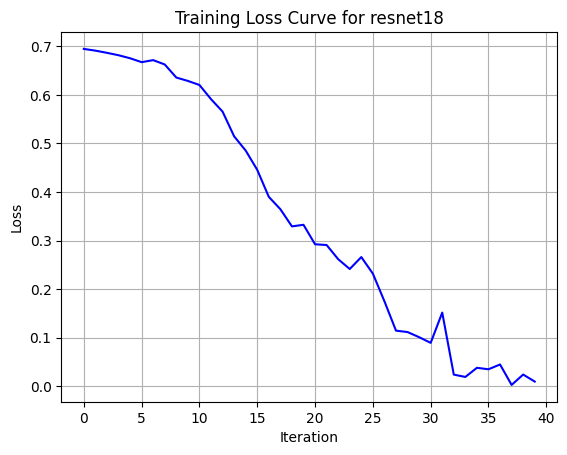

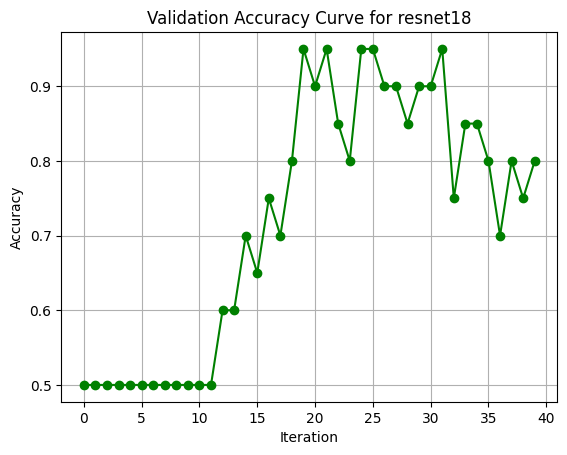

In [8]:
# 训练+画图

loss_curve, acc_curve_x, acc_curve_y = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    log_interval=1
)

plot_training_curves(loss_curve, acc_curve_x, acc_curve_y, pretrain_network)





In [9]:
from torchinfo import summary
summary(model, input_size=(1, 3, 320, 320))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 160, 160]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 160, 160]         128
├─ReLU: 1-3                              [1, 64, 160, 160]         --
├─MaxPool2d: 1-4                         [1, 64, 80, 80]           --
├─Sequential: 1-5                        [1, 64, 80, 80]           --
│    └─BasicBlock: 2-1                   [1, 64, 80, 80]           --
│    │    └─Conv2d: 3-1                  [1, 64, 80, 80]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 80, 80]           128
│    │    └─Identity: 3-3                [1, 64, 80, 80]           --
│    │    └─ReLU: 3-4                    [1, 64, 80, 80]           --
│    │    └─Identity: 3-5                [1, 64, 80, 80]           --
│    │    └─Conv2d: 3-6                  [1, 64, 80, 80]           36,864
│ 